Доброго времени суток.

В общем и целом мы имеем ежемесячные данные за последние почти 4 года по ключевой ставке и средней ипотечной ставке среди крупнейших банков. В качестве индикатора для ключевой ставки был взят однодневный MIACR, так как он меняется постоянно и "накрывает" ставку ЦБ. <br>
У нас есть временные ряды и задача провести исследование касаемо влияния ключевой ставки на ипотечную ставку. Погнали.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
sns.set(rc={'figure.figsize':(11, 6)})

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_excel('mortgage rate.xlsx')
df.drop(df.columns.difference(['Отчетная дата', 'Средневзвешенная ставка по кредитам, выданным в течение месяца, %',
                               'key rate']), 1, inplace=True)
df.rename(columns={'Отчетная дата': 'date', 
                   'Средневзвешенная ставка по кредитам, выданным в течение месяца, %' : 'mortgage rate'}, 
          inplace = True)
df.date = pd.to_datetime(df.date, format = '%d.%m.%Y')
df['key rate'] = df['key rate'][::-1].values
df.set_index('date', inplace = True)
df.head(6)

,mortgage rate,key rate
date,,
2018-01-01,9.74,7.11
2018-02-01,9.79,7.02
2018-03-01,9.70,7.03
2018-04-01,9.58,6.75
2018-05-01,9.55,6.94
2018-06-01,9.48,7.12


## Визуализируем имеющиеся данные

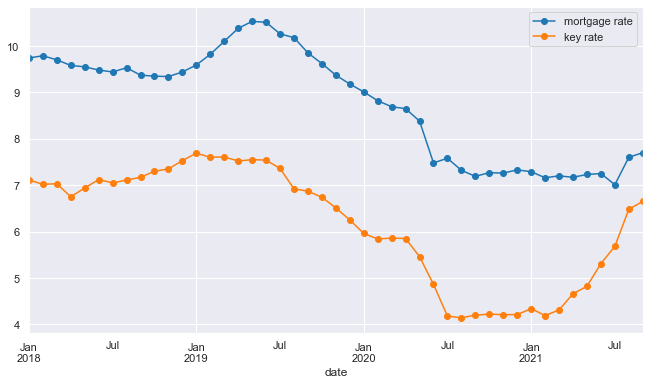

In [3]:
df.plot(marker='o', legend = True, color = ("#1f77b4", "#ff7f0e"));

По картинке видна, что не странно, существенная корреляция между показателями.

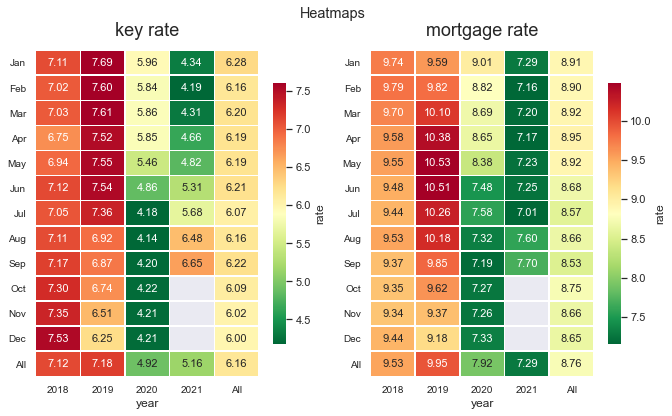

In [4]:
import calendar
fig, (ax1, ax2) = plt.subplots(1,2, sharex=True, figsize=(11,6))
fig.suptitle('Heatmaps')
ax1.set_title('key rate', fontdict={'fontsize':18}, pad=14);
ax2.set_title('mortgage rate', fontdict={'fontsize':18}, pad=14);

df['year'] = df.index.year
df['month'] = df.index.month

pivot_df = pd.pivot_table(df, values = 'key rate', 
                          index = ['month'], columns = ['year'],
                          margins = True, fill_value=0)

named_index = [[calendar.month_abbr[i] if isinstance(i, int) else i for i in list(pivot_df.index)]] # name months
all_month_year_df = pivot_df.set_index(named_index)
all_month_year_df.iloc[9:12, 3] = np.nan

sns.heatmap(all_month_year_df, cmap='RdYlGn_r', robust=True, fmt='.2f',
        annot=True, linewidths=.5, annot_kws={'size':11},
        cbar_kws={'shrink':.8, 'label':'rate'}, ax = ax1)

ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0, fontsize=10);
ax1.set_xticklabels (ax1.get_xticklabels(), rotation=0, fontsize=10);

pivot_df = pd.pivot_table(df, values = 'mortgage rate', 
                          index = ['month'], columns = ['year'],
                          margins = True, fill_value=0)

named_index = [[calendar.month_abbr[i] if isinstance(i, int) else i for i in list(pivot_df.index)]] # name months
all_month_year_df = pivot_df.set_index(named_index)
all_month_year_df.iloc[9:12, 3] = np.nan

sns.heatmap(all_month_year_df, cmap='RdYlGn_r', robust=True, fmt='.2f',
        annot=True, linewidths=.5, annot_kws={'size':11},
        cbar_kws={'shrink':.8, 'label':'rate'}, ax = ax2)

ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0, fontsize=10);
ax2.set_xticklabels (ax2.get_xticklabels(), rotation=0, fontsize=10);

df.drop(['year', 'month'], axis = 1,inplace = True)

По хитмапам также наблюдается хорошая взаимосвязь переменных.

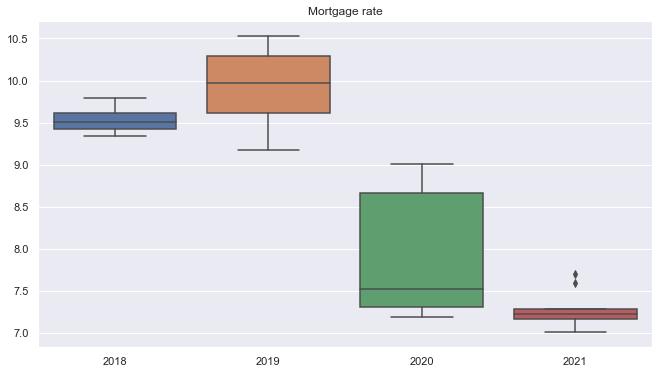

In [5]:
from pandas import Grouper

df.index = pd.to_datetime(df.index, format='%d.%m.%Y')
groups = df.groupby(Grouper(freq='QS'))
years = pd.DataFrame(columns = ['2018', '2019', '2020', '2021'], )
i = 0; l=[]
for name, group in groups:
    if str(name.year) == years.columns[i] :
        s1 = years[str(name.year)].dropna()
        s2 = pd.Series(group.values.flatten()[::2])
        l.extend(pd.concat([s1, s2]).values)
    else :
        years[str(name.year-1)] = l
        i += 1
        l = list(pd.Series(group.values.flatten()[::2]))

years[str(name.year)] = l + [np.nan]*(12-len(l))
sns.boxplot(data = years).set_title('Mortgage rate');

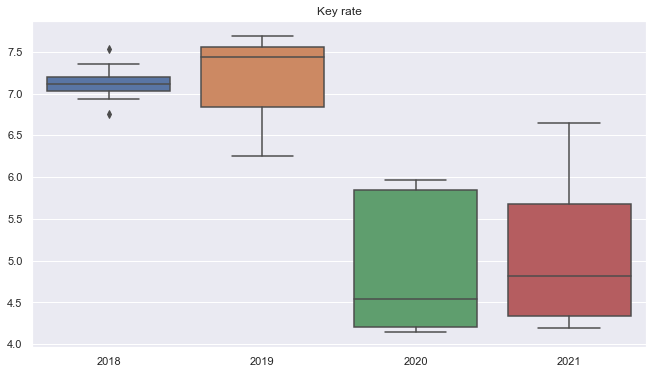

In [6]:

years = pd.DataFrame(columns = ['2018', '2019', '2020', '2021'], )
i = 0; l=[]
for name, group in groups:
    if str(name.year) == years.columns[i] :
        s1 = years[str(name.year)].dropna()
        s2 = pd.Series(group.values.flatten()[1::2])
        l.extend(pd.concat([s1, s2]).values)
    else :
        years[str(name.year-1)] = l
        i += 1
        l = list(pd.Series(group.values.flatten()[1::2]))

years[str(name.year)] = l + [np.nan]*(12-len(l))
sns.boxplot(data = years).set_title('Key rate');

Боксплоты (или ящики с усами) демонстрируют почти полную идентичность в распределении изменчивости ставок в течение каждого года (кроме не показательного последнего).

**В принципе**, <br> 
мы могли бы сделать следующее (и это было бы полезно): можно попробовать засплитить даннные в аддитивную модель, то есть
* Trend (общее направление движения)
* \+ Seasonality (периодический паттерн во временных рядах)
* \+ Noise (nan либо выбросы)

Данных очень мало, поэтому судить о полной корректности полученных значений не стоит.

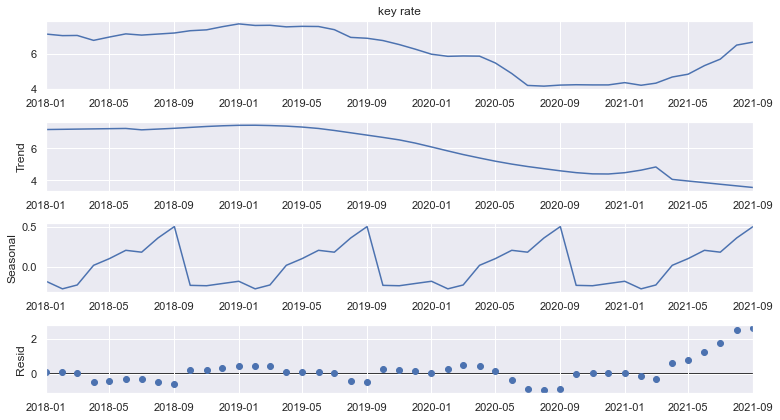

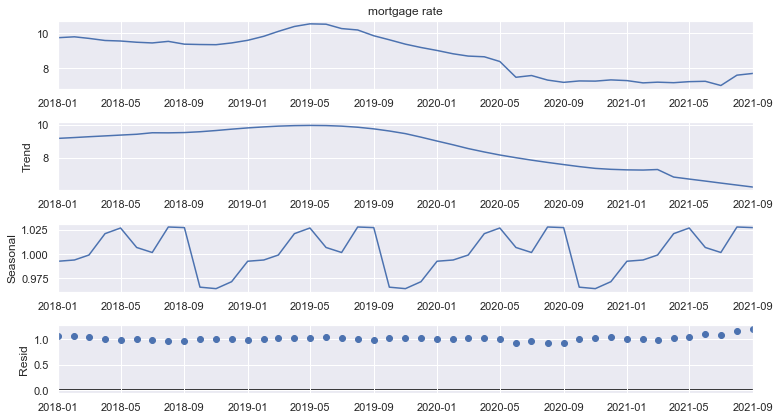

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

add1 = seasonal_decompose(df['key rate'], model='additive', extrapolate_trend='freq')
add2 = seasonal_decompose(df['mortgage rate'], model='multiplicative', extrapolate_trend='freq')
add1.plot()#.suptitle('Key rate', fontsize=22, y=0.92)
add2.plot()#.suptitle('Mortgage rate', fontsize=22, y=0.92)
plt.show()

Мы могли бы убрать сезонность с ошибками и взять только значение тренда, если бы вследствие этого наши данные стали лучше. Например, ряды стали бы стационарными после такой трансформации. Проверим, станут ли, с помощью теста Дики-Фуллера.

In [8]:
df_ = pd.DataFrame({'key rate': add1.trend, 'mortgage rate': add2.trend})
from statsmodels.tsa.stattools import adfuller

X = df_.iloc[:, 0].values
result = adfuller(X)
print('Values for key rate')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

print('---------------')

X = df_.iloc[:, 1].values
result = adfuller(X)
print('Values for mortgage rate')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('\nCritical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

Values for key rate
ADF Statistic: 1.370019
p-value: 0.996974
---------------
Values for mortgage rate
ADF Statistic: 0.042078
p-value: 0.961877

Critical Values:
	1%: -3.597
	5%: -2.933
	10%: -2.605


Как можно было предположить, поведение ставок вряд ли является стационарным во времени (см. p-value и критические значения).

## Time to modelling

### OLS

**Gauss-Markov assumptions for time series** <br>
Чтобы быть уверенными, что наша оценка вектора $\beta$ является BLUE, хорошо бы учитывать предположения, которые мы закладываем в модель:
1. Linear. <br>
Модель регрессии должна быть линейна относительно $\beta$ (не не обязательно относительно $x$). То есть мы рассматриваем класс оценок $\beta$, которые являются линейной функцией относительно $y$.
2. Zero conditional mean on zeros. <br>
$E[u_t|x_{jk}]=0$ for $j$ in regressors vector ank $k$ in $1..T$
3. No perfect collinearity. <br>
Отсутствие коллинеарности между регрессорами.
4. Homoscedasticity. <br>
Дисперсия ошибки постоянна и не зависит от регрессора: $var(u_t|x_{jk})=\sigma^2$
5. No error\`s correlation. <br>
$cov(u_t, u_s | x_{jk})=0$
6. Exogeneity (на самом деле следует из 2 пункта) <br>
${\displaystyle E(x_{t}^{T}u _{t})=0}$

Мы строим линейную модель. Коллинеарности между регрессорами не будет, поскольку имеем парную регрессию. Верим в гомоскедастичность, исходя из графиков выше. Вспомним далее и про экзогенность.

#### Linear regression 

                            OLS Regression Results                            
Dep. Variable:          mortgage rate   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     188.3
Date:                Sat, 30 Oct 2021   Prob (F-statistic):           2.60e-17
Time:                        00:32:08   Log-Likelihood:                -32.695
No. Observations:                  45   AIC:                             69.39
Df Residuals:                      43   BIC:                             73.00
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5344      0.389      9.097      0.0

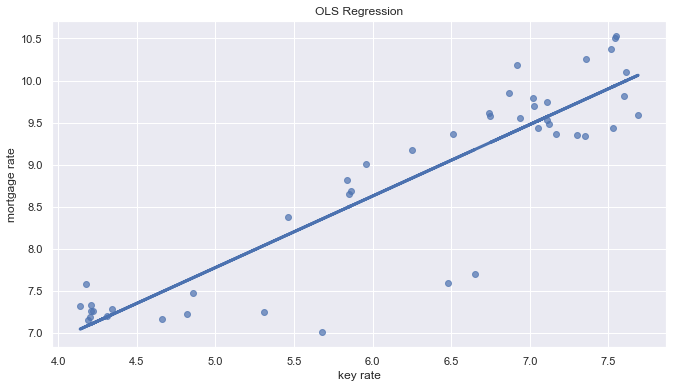

In [9]:
import statsmodels.api as sm

X = sm.add_constant(df['key rate'])
model = sm.OLS(df['mortgage rate'], X)
results = model.fit()

plt.scatter(df['key rate'], df['mortgage rate'],alpha=0.7)
y_predict = results.params[0] + results.params[1]*df['key rate']
plt.plot(df['key rate'], y_predict, linewidth=3)

plt.xlabel('key rate')
plt.ylabel('mortgage rate')
plt.title('OLS Regression')

print(results.summary())

Поскольку вектор $\beta$ асимптотически нормален (следствие ЦПТ и конечности 4-х моментов у ошибки и регрессоров), то в табличке выше приводится в том числе проверка гипотезы о статистической значимости коэффицентов с помощью t-теста (полученное значение, вероятность получить большее значение при правильной нулевой гипотезе и доверительный интервал на 5% уровне значимости). <br>Как можно увидеть, полученные OLS оценки статистически значимы и хорошо объясняют поведение ипотечной ставки (см. $R^2$ в таблице).

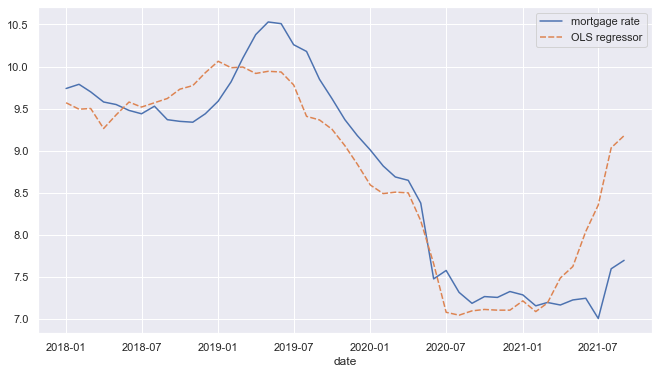

In [10]:
df['OLS regressor'] = 3.5344 + 0.8490*df['key rate']
sns.lineplot(data = df.drop(['key rate'], axis=1));

### Лаг 
Если нанести наши данные на график, то он будет выглядить следующим образом:

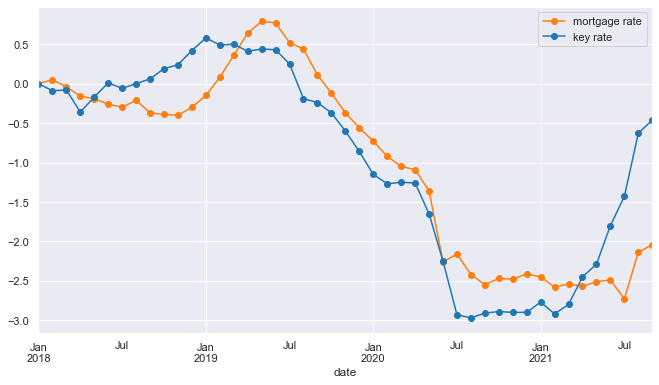

In [11]:
df.sub(df.iloc[0]).drop('OLS regressor', axis=1).plot(marker='o', legend = True, color = ("#ff7f0e", "#1f77b4"));

Мы могли бы сдвинуть значения по ипотеке на 3 месяца и получили бы такой график:

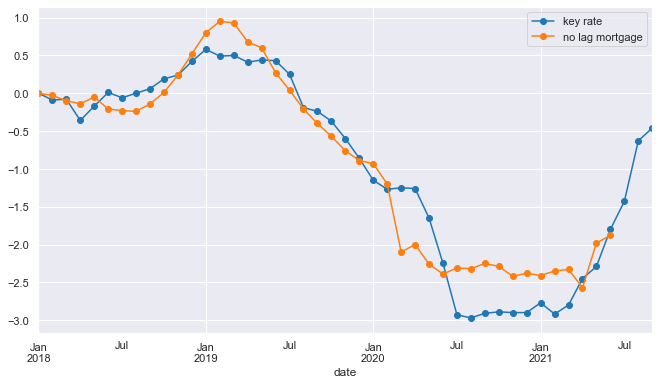

In [12]:
df['no lag mortgage'] = df['mortgage rate'][3:].append(pd.Series([np.nan]*3)).values
df.iloc[:, 1:].sub(df.iloc[0]).drop(['OLS regressor', 'mortgage rate'], axis=1).plot(marker='o', 
                                                                  legend = True, color = ("#1f77b4", "#ff7f0e"));
# plt.title('lagged graph (3 months)', fontsize = 15);

Кажется, что ипотечная ставка с опозданием реагирует на изменение ключевой ставки, что вполне укладывается в рамки реальной жизни. <br>
Можно было бы попробовать построить новую регрессию со сдвинутыми данными.

**Linear regression**

                            OLS Regression Results                            
Dep. Variable:        no lag mortgage   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     475.2
Date:                Sat, 30 Oct 2021   Prob (F-statistic):           8.24e-24
Time:                        00:32:09   Log-Likelihood:                -12.526
No. Observations:                  42   AIC:                             29.05
Df Residuals:                      40   BIC:                             32.53
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2558      0.255     12.786      0.0

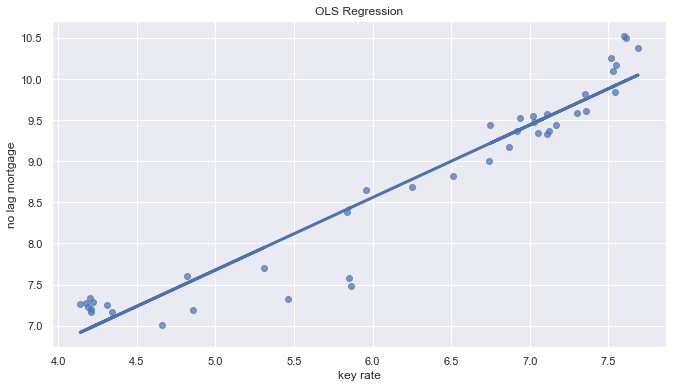

In [13]:
df1 = df.iloc[:-3, :]

X = sm.add_constant(df1['key rate'])
model = sm.OLS(df1['no lag mortgage'], X)
results = model.fit()

plt.scatter(df1['key rate'], df1['no lag mortgage'],alpha=0.7)
y_predict = results.params[0] + results.params[1]*df1['key rate']
plt.plot(df1['key rate'], y_predict, linewidth=3)

plt.xlabel('key rate')
plt.ylabel('no lag mortgage')
plt.title('OLS Regression')

print(results.summary())

**ADL**

Такая "сдвинутая" регрессия, конечно, лучше объясняет зависимость (см. $R^2$). *Однако теперь наша модель имеет эндогенность*, а, соответственно, оценка смещена. <br>
Что мы понимаем:
1. Ипотечная ставка зависит имеет тенденцию к авторегрессии (см. рисунок ниже)
2. Сама ключевая ставка влияет на ипотечную с лагом. <br>

В таком случае можно было бы попробовать использовать **ADL** модель - Autoregressive distributive lag model, которая в самом общем случае имеет следующий вид:

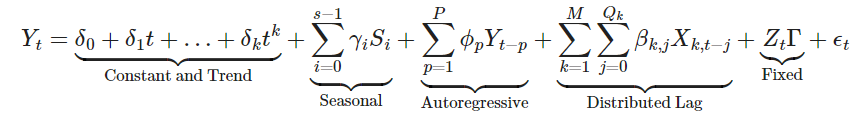
      
Нам же хватит, например, следующей постановки: <br>

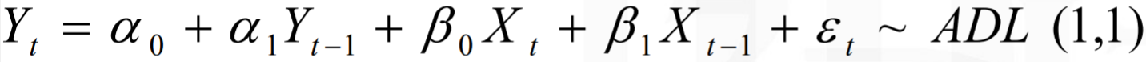

Ключевое различие между AR моделью и ARDL в том, что ARDL фокусируется на экзогенных регрессорах и выборе оптимального вектора лагов для независимой и объясняющей переменных.
    
Нашей задачей является подобрать такие $p,q$ в $ADL(p,q)$, которые бы лучше всего объясняли нашу зависимость.

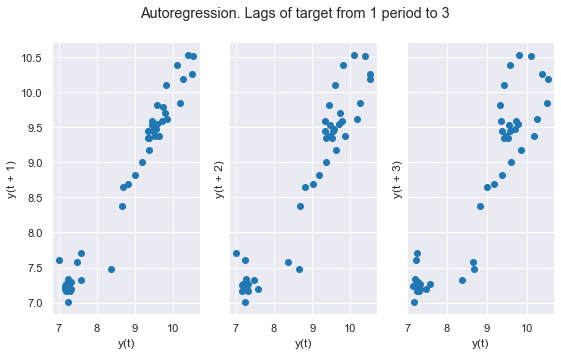

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(9, 5), sharey = True)
pd.plotting.lag_plot(df['mortgage rate'], lag = 1, ax=axes[0], c = "#1f77b4");
pd.plotting.lag_plot(df['mortgage rate'], lag = 2, ax=axes[1], c = "#1f77b4");
pd.plotting.lag_plot(df['mortgage rate'], lag = 3, ax=axes[2], c = "#1f77b4");
fig.suptitle("Autoregression. Lags of target from 1 period to 3");

Однако, поскольку нашей задачей является выявление зависимости ипотечной ставки от ключевой, а не моделирование ее изменчивости во времени, то сейчас мы не будем рассматривать лаг таргета.

Подбирать параметры модели будем по критерию Акаике: <br>
$AIC = nln(RSS/n) + 2k$ <br>

Модель "плохая", если она:
1. Плохо предсказывает (RSS большой)
2. Сложная (много коэфф-ов, больше регрессоров). <br>

Поскольку у нас фиксированное количество регрессоров, то сравнивать критерий будет по RSS.

Тут нужно упомянуть несколько пунктов:
* Будем считать, что влияние изменения ключевой ставки проявит себя не позже, чем через 6 месяцев. 
* Мы не знаем, есть ли какой-то тренд в изменении ставки, поэтому построим сначала модель с ним, и если тренд окажется статистически незначимым, то построим уже без него. В обе модели при этом включается константа.

In [15]:
from statsmodels.tsa.api import ARDL
from statsmodels.tsa.ardl import ardl_select_order

df.index = pd.date_range(start=pd.datetime(2018, 1, 1), periods=len(df), freq='MS')

sel_res_ct = ardl_select_order(
    df['mortgage rate'], 0, df[['key rate']], 6, trend="ct", glob = True
)

print(f"The optimal lag vector for model with constant and trend is: {sel_res_ct.model.ardl_order}")

res2 = sel_res_ct.model.fit()
print('\nCONSTANT AND TREND')
display(res2.summary())

The optimal lag vector for model with constant and trend is: (0, 4)

CONSTANT AND TREND


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARDL Model Results                              
==============================================================================
Dep. Variable:          mortgage rate   No. Observations:                   45
Model:                     ARDL(0, 4)   Log Likelihood                  -4.955
Method:               Conditional MLE   S.D. of innovations              0.270
Date:                Sat, 30 Oct 2021   AIC                             19.911
Time:                        00:32:10   BIC                             28.944
Sample:                    05-01-2018   HQIC                            23.278
                         - 09-01-2021                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           3.4480      0.631      5.463      0.000       2.173       4.723
trend          -0.0057      0.008     -0.737      0.465      -0.021       0.010
key rate.L1     0.4424      0.081      5.447      0.000       0.278       0.606
key rate.L4     0.4338      0.093      4.663      0.000       0.246       0.622
===============================================================================
"""

Гипотезу о статистической значимости тренда отклоняем - 95% доверительный интервал включает в себя 0 (скорее 0 даже находится где-то посередине интервала).

In [16]:
sel_res_c = ardl_select_order(
    df['mortgage rate'], 0, df[['key rate']], 6, trend="c", glob = True
)
print(f"The optimal lag vector for model with constant only is: {sel_res_c.model.ardl_order}")

res1 = sel_res_c.model.fit()
print('\nONLY CONSTANT')
display(res1.summary())

The optimal lag vector for model with constant only is: (0, 4)

ONLY CONSTANT


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARDL Model Results                              
==============================================================================
Dep. Variable:          mortgage rate   No. Observations:                   45
Model:                     ARDL(0, 4)   Log Likelihood                  -5.284
Method:               Conditional MLE   S.D. of innovations              0.272
Date:                Sat, 30 Oct 2021   AIC                             18.567
Time:                        00:32:10   BIC                             25.794
Sample:                    05-01-2018   HQIC                            21.261
                         - 09-01-2021                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           3.0162      0.234     12.901      0.000       2.544       3.488
key rate.L1     0.4530      0.079      5.702      0.000       0.293       0.613
key rate.L4     0.4701      0.078      5.989      0.000       0.312       0.628
===============================================================================
"""

Получаем в таком случае следующую модель:

$Y_t = 3.0162 +  0.4530X_{t-1} + 0.4701X_{t-4}$ <br>

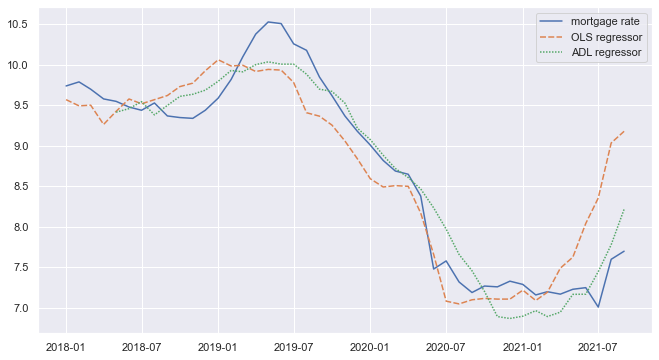

In [17]:
df['ADL regressor'] = 3.0162 + \
                    0.4530*pd.Series([np.nan]*1).append(df['key rate'][:-1]).values + \
                    0.4701*pd.Series([np.nan]*4).append(df['key rate'][:-4]).values
sns.lineplot(data = df.drop(['key rate', 'no lag mortgage'], axis = 1));

In [18]:
from sklearn.metrics import r2_score

print('ADL model`s R-squared equals to {}'.format(r2_score(df['mortgage rate'][4:], df['ADL regressor'][4:])))

ADL model`s R-squared equals to 0.9412366052701594


Вышло хорошо. <br>
Хотя наша модель и усложнилась, в итоге мы получили коэф-т детерминации лучше, чем дал нам OLS. <br>
Но можем ли мы сделать еще лучше?

**full ADL**

Если не ограничиваться только независимыми переменными и добавить немного авторегрессии, можно получить следующее:

In [19]:
sel_res_c = ardl_select_order(
    df['mortgage rate'], 3, df[['key rate']], 6, trend="c", glob = True
)

sel_res_ct = ardl_select_order(
    df['mortgage rate'], 3, df[['key rate']], 6, trend="ct", glob = True
)

print(f"The optimal lag vector for model with constant only is: {sel_res_c.model.ardl_order}")
print(f"The optimal lag vector for model with constant and trend is: {sel_res_ct.model.ardl_order}")

The optimal lag vector for model with constant only is: (1, 0)
The optimal lag vector for model with constant and trend is: (1, 0)


In [20]:
res1 = sel_res_c.model.fit()
print('\nONLY CONSTANT')
display(res1.summary())
res2 = sel_res_ct.model.fit()
print('--------------')
print('CONSTANT AND TREND')
display(res2.summary())


ONLY CONSTANT


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARDL Model Results                              
==============================================================================
Dep. Variable:          mortgage rate   No. Observations:                   45
Model:                     ARDL(1, 0)   Log Likelihood                  14.966
Method:               Conditional MLE   S.D. of innovations              0.172
Date:                Sat, 30 Oct 2021   AIC                            -21.933
Time:                        00:32:11   BIC                            -14.796
Sample:                    02-01-2018   HQIC                           -19.286
                         - 09-01-2021                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.4857      0.220      2.206      0.033       0.041       0.930
mortgage rate.L1     0.7953      0.045     17.667      0.000       0.704       0.886
key rate.L0          0.2064      0.042      4.885      0.000       0.121       0.292
====================================================================================
"""

--------------
CONSTANT AND TREND


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARDL Model Results                              
==============================================================================
Dep. Variable:          mortgage rate   No. Observations:                   45
Model:                     ARDL(1, 0)   Log Likelihood                  15.226
Method:               Conditional MLE   S.D. of innovations              0.171
Date:                Sat, 30 Oct 2021   AIC                            -20.453
Time:                        00:32:11   BIC                            -11.532
Sample:                    02-01-2018   HQIC                           -17.145
                         - 09-01-2021                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.7594      0.455      1.671      0.103      -0.159       1.678
trend               -0.0027      0.004     -0.690      0.494      -0.011       0.005
mortgage rate.L1     0.7739      0.055     14.094      0.000       0.663       0.885
key rate.L0          0.2027      0.043      4.733      0.000       0.116       0.289
====================================================================================
"""

Как и в прошлый раз, тренд не показал своей значимости, поэтому берем коэффициенты из 1 таблицы.

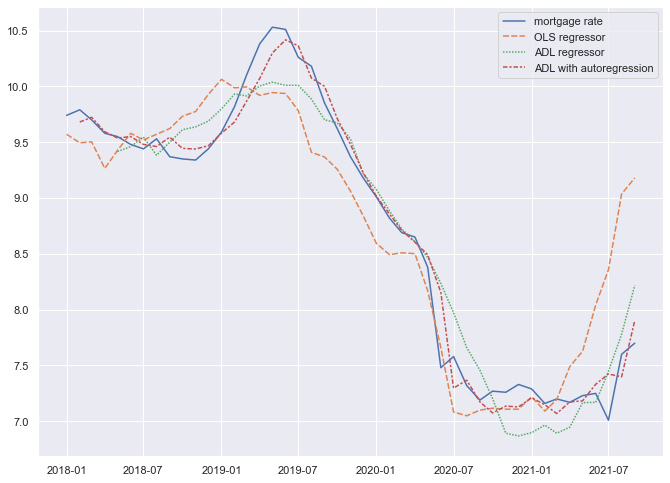

In [21]:
df['ADL with autoregression'] = 0.4857 + \
                    0.7953*pd.Series([np.nan]*1).append(df['mortgage rate'][:-1]).values + \
                    0.2064*df['key rate'].values
sns.set(rc={'figure.figsize':(11.2,8.27)})
sns.lineplot(data = df.drop(['key rate', 'no lag mortgage'], axis = 1));

In [22]:
print('ADL with autoregression got R-squared equalled to {}'.format(r2_score(df['mortgage rate'][1:], 
                                                                     df['ADL with autoregression'][1:])))

ADL with autoregression got R-squared equalled to 0.9781202490334812


## In conclusion

Что сделали и к чему пришли:
1. Провели визуальный анализ имеющихся данных;
2. Построили линейную регрессию, получив $R^2$ = 0.814;
3. Заметили, что ипотечная ставка реагирует на изменение ключевой ставки с лагом, и можно использовать эту информацию для построения более интересных моделей:
    * Снова применили МНК. Получили $R^2$ = 0.92, отметили существенные недостатки оценок;
    * Построили линейную регрессию, которая учитывает лаги только объясняющих переменных, i.e. $ADL(0,q)$, получив $R^2$ = 0.94;
    * Построили линейную регрессию, учитывающую и лаги, и автокорреляцию, i.e. $ADL(p,q)$, получив у $R^2$ почти 0.98;

Таким образом, каждая из наших моделей показывает, что ключевая ставка существенно влияет на ставку по ипотекам у крупнейших банков с некоторым лагом порядка 3-4 месяцев. Лучше всего проявила себя ADL с авторегрессией, показав очень достойный результат.

На этом все, спасибо за внимание :)